# BIG DATA - Apprentissage supervisé

Ce travail a pour but d'analyser plusieurs jeu de données de faire apprendre des modèles de ML afin de créer des classifiers efficace.

In [12]:
## Import des libraires
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score
from utils import get_final_imputed_dataset, get_categories_numeric_columns_ids, binarisation, analyse_data_properties_2, keep_only_numeric, normalize_data_one, import_data, get_data_variables, analyse_data_properties, launch_clfs, normalize_data, apply_pca, get_concatenated_data, plot_measures_methods_difference, plot_variables_importance, number_variables_to_keep, find_best_variables, run_classifiers
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I. Apprentissage supervisé : Feature engineering et Classification

## 1 - Chargement des données et préparation

Ce jeu de données contient des informations sur des clients d'une banque et si ces derniers sont des bons ou mauvais payeurs. L'objectif ici est de faire apprendre des modèles sur cette base de données afin de pouvoir identifier les potentiels bon payeurs pour la banque.

In [17]:
data = import_data()
X,y = get_data_variables(data)

In [18]:
data.head()

,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,Status
0,9.0,1.0,60.0,30.0,0.0,1.0,1.0,73.0,129.0,0.0,0.0,800.0,846.0,1
1,17.0,1.0,60.0,58.0,1.0,1.0,0.0,48.0,131.0,0.0,0.0,1000.0,1658.0,1
2,10.0,0.0,36.0,46.0,0.0,2.0,1.0,90.0,200.0,3000.0,0.0,2000.0,2985.0,0
3,0.0,1.0,60.0,24.0,1.0,1.0,0.0,63.0,182.0,2500.0,0.0,900.0,1325.0,1
4,0.0,1.0,36.0,26.0,1.0,1.0,0.0,46.0,107.0,0.0,0.0,310.0,910.0,1


L'échantillon contient 4375  individus décrits par 14 variables
Pourcentage de positifs :  72.20571428571428
Pourcentage de négatifs :  27.794285714285717
Ainsi pour être bon, nos modèles doivent avoir une accuracy supérieur à 72.20571428571428
Les modèles seront donc plus performants que le hasard.


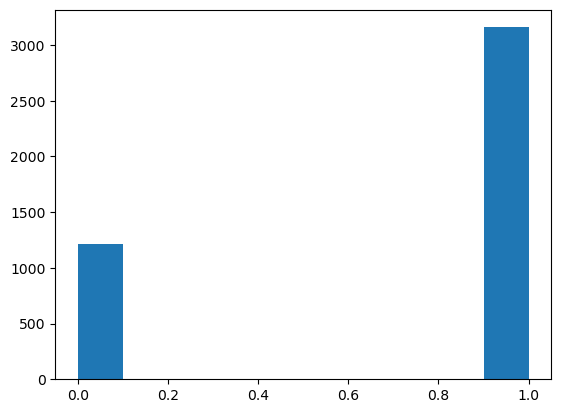

In [19]:
analyse_data_properties(data,y)

In [20]:
# Creation des jeux de données de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


## 2 - Apprentissage et évaluations des modèles

Nous allons comparer les trois algorithmes suivants en utilisant leur accuracy et leur précision. On choisit la précision ici car ce que l'on veut eviter le plus sont les faux positifs. En effet, ici le pire cas serait d'attribuer un crédit à quelqu'un qui ne va potentiellement pas rembourser car cela fera perdre de l'argent à la banque. On veut donc maximiser la précision.

In [21]:
clfs = {
        "DT": DecisionTreeClassifier(criterion="gini", random_state=1),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "MLP": MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
}

In [22]:
clfs_measures = launch_clfs(clfs, X_train, y_train, X_test, y_test)

[[ 325  279]
 [ 318 1266]]
Pour DT : Accuracy = 72.71 %, Precision = 81.94 %

[[ 189  415]
 [ 187 1397]]
Pour KNN : Accuracy = 72.49 %, Precision = 77.10 %

[[  78  526]
 [  53 1531]]
Pour MLP : Accuracy = 73.54 %, Precision = 74.43 %



Ainsi, on peut voir que l'algorithme avec la meilleur accuracy est MLP cependant, on remarque que sa précision est la plus faible des trois.Les accuracy de l'arbre CART et de K-neighbours sont très proche cepdendant avec l'arbre CART on a une différence notable entre les précisions. Or on veut maximiser la précision. Finalement, on va donc choisir l'arbre CART qui maximise la précision avec une bonne accuracy (très proche de l'accuracy de MLP).

## 3 - Normalisation des variables continues

In [23]:
# On normalise nos jeux de données
X_train_norm, X_test_norm = normalize_data(X_train,X_test)

In [24]:
# On relance les classifieurs
clfs_measures_norm = launch_clfs(clfs, X_train_norm, y_train, X_test_norm, y_test)

[[ 322  282]
 [ 315 1269]]
Pour DT : Accuracy = 72.71 %, Precision = 81.82 %

[[ 286  318]
 [ 223 1361]]
Pour KNN : Accuracy = 75.27 %, Precision = 81.06 %

[[ 342  262]
 [ 227 1357]]
Pour MLP : Accuracy = 77.65 %, Precision = 83.82 %



Avec les données normalisées, on remarque que la tendance s'inverse. En effet, nous avons ici un classifieur qui maximise à la fois l'accuracy et la précision. C'est le MLP. Comparé à l'itération d'avant on a une bien meilleure accuracy et une bien meilleure précision que précédemment. On remarque que cela est aussi le cas pour le KNN. En effet, l'accuracy et la précision se sont bien améliorés avec la normalisation des données. Cependant, pour le DT on remarque que l'accuracy n'a pas bougée et que la précision a diminué très légerement. On choist donc dans ce cas le MLP.

## 4 - Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales

In [25]:
## On fait une acp sur les données et on récupère 3 nouvelles dimensions
X_train_pca, X_test_pca = apply_pca(X_train_norm, X_test_norm, 3)

## On concatène les nouvelles variables X_train_norm et X_test_norm
X_train_concat, X_test_concat = get_concatenated_data(X_train_pca, X_train_norm, X_test_pca, X_test_norm)

On relance nos classifiers avec les données normalisés et avec les nouvelles dimensions de l'ACP.

In [26]:
# On relance les classifieurs
clfs_measures_norm_acp = launch_clfs(clfs, X_train_concat, y_train, X_test_concat, y_test)

[[ 333  271]
 [ 349 1235]]
Pour DT : Accuracy = 71.66 %, Precision = 82.01 %

[[ 283  321]
 [ 212 1372]]
Pour KNN : Accuracy = 75.64 %, Precision = 81.04 %

[[ 319  285]
 [ 210 1374]]
Pour MLP : Accuracy = 77.38 %, Precision = 82.82 %



In [27]:
print(clfs_measures)
print(clfs_measures_norm)
print(clfs_measures_norm_acp)

# On compare les resultats obtenus avec les classifieurs


{'DT': {'acc': 0.7271480804387569, 'precision': 0.8194174757281554}, 'KNN': {'acc': 0.7248628884826326, 'precision': 0.7709713024282561}, 'MLP': {'acc': 0.7353747714808044, 'precision': 0.7442877977637335}}
{'DT': {'acc': 0.7271480804387569, 'precision': 0.8181818181818182}, 'KNN': {'acc': 0.7527422303473492, 'precision': 0.8106015485407981}, 'MLP': {'acc': 0.776508226691042, 'precision': 0.8381717109326745}}
{'DT': {'acc': 0.716636197440585, 'precision': 0.8200531208499336}, 'KNN': {'acc': 0.756398537477148, 'precision': 0.8103957471943296}, 'MLP': {'acc': 0.7737659963436929, 'precision': 0.8282097649186256}}


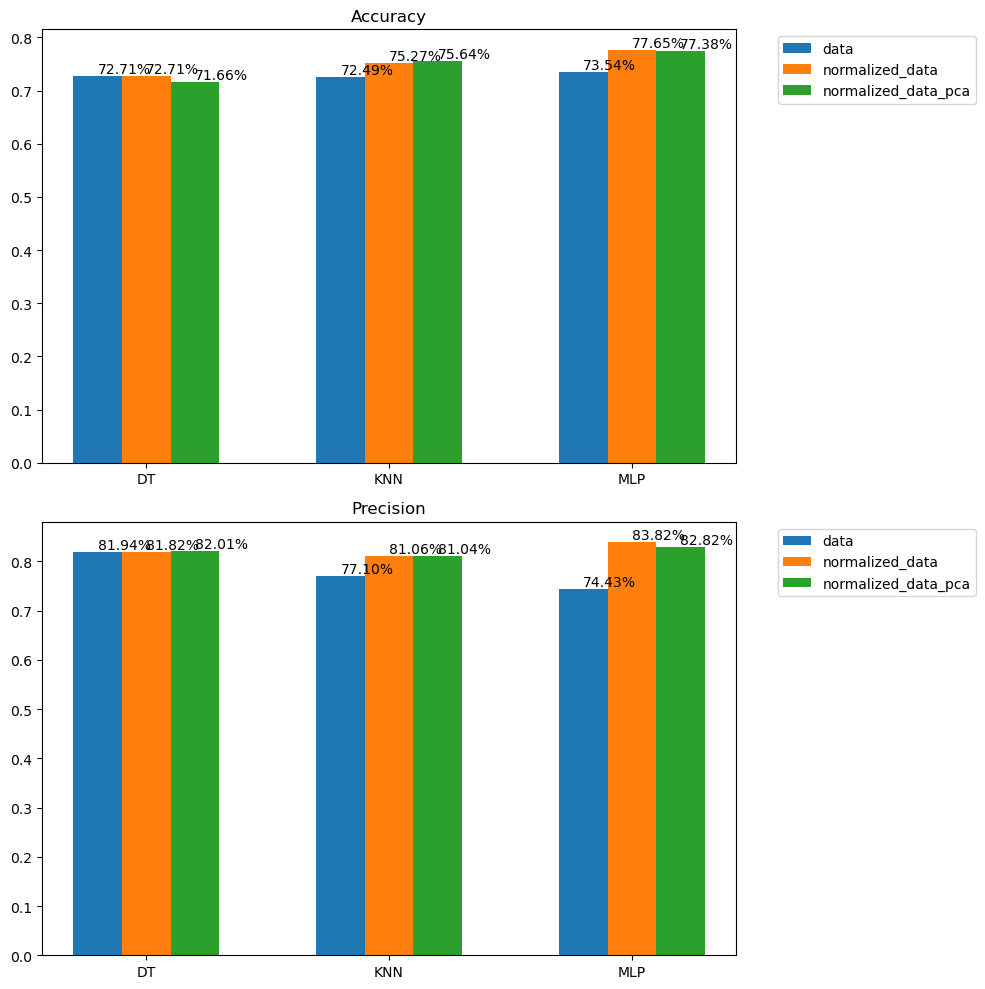

In [28]:
plot_measures_methods_difference(clfs_measures, clfs_measures_norm, clfs_measures_norm_acp)


Ainsi grâce au graphique ci-dessus, on peut voir que l'acp a permis d'améliorer les performances (accuracy et precision) du knn seulement. Pour le DT on a de bien moins bonnes performances avec les données normalisés et l'acp que seulement avec la normalisation ou bien sans. Ensuite, pour le MLP on a la même précision avec l'acp que juste avec les données normalisés. Cependant on peut remarque qu'avec l'acp on a une accuracy un peut moins bonne. On passe de `83.82` à `83.30`. Ainsi, le classifieur qui maximise à la fois l'accuracy et la précision est le MLP sans l'acp seulement avec les données normalisés. C'est donc ce que l'on va garder pour la suite.

## 5 - Séléction de variables

Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records', 'Time', 'Job', 'Debt', 'Home', 'Marital'],
      dtype='object')


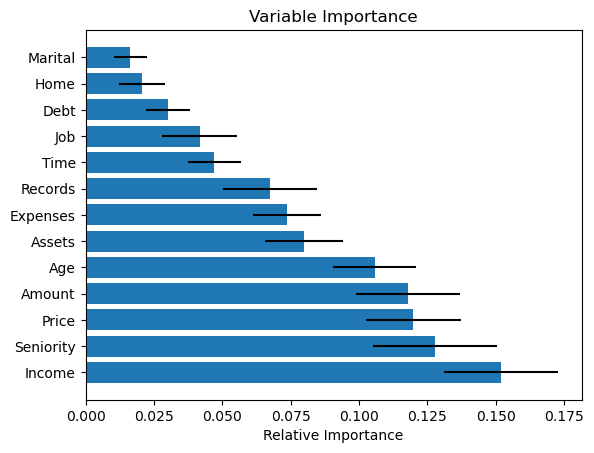

In [29]:
sorted_idx = plot_variables_importance(X_train_norm, y_train, data)

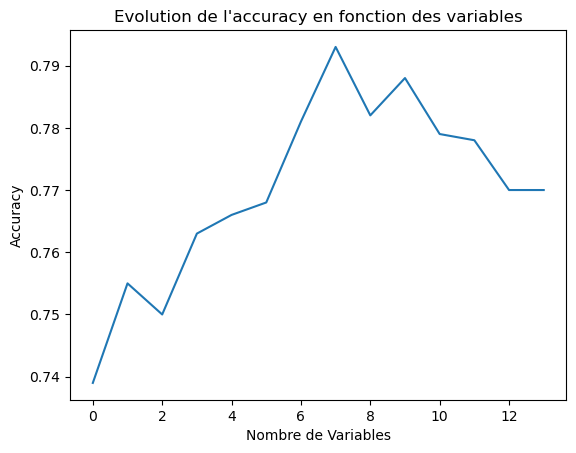

In [30]:
number_variables_to_keep(X_train_norm, X_test_norm, y_test, y_train, sorted_idx, MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1))

Ainsi, avec le graphique précédent on peut voir que le nombre de variables qui maximise l'accuracy est 7. On arrive a un accuracy de 0.70. Or on s'aperçoit que pour 0 variables, on obtient une accuracy de 0.74. De plus, lorsque l'on regarde le code on s'aperçoit que le nombre de variables affiché est plutot jusqu'a que indice de variables on va. Ce qui signifie qu'il faut ajouter +1 a la valeur que l'on lit dans le graphique. 

Le nombre de variables qui maximise l'accuracy est donc 8 en prenant les 8 meilleures variables.

On peut ainsi déduire que les autres variables sont superflues. En combinant les resultats de ce graphique et du graphique précédent, on peut conclure que les variables a garder sont : 
* Income
* Seniority
* Price
* Amount
* Age
* Assets
* Expenses
* Records

## 6 - Paramétrage des classifiers

In [31]:
# On supprime les variables les moins importantes
X_train_norm_bv = X_train_norm[:, sorted_idx[:8]]
X_test_norm_bv = X_test_norm[:, sorted_idx[:8]]

In [39]:
clf = MLPClassifier()
params = {
    "hidden_layer_sizes": [(40, 20), (40, 10), (20,), (10,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
}
best_params_mlp = find_best_variables(X_train_norm_bv, y_train, X_test_norm_bv, y_test, clf, params)

Meilleurs paramètres trouvés:
{'activation': 'logistic', 'hidden_layer_sizes': (40, 10)}
Accuracy du modèle sur l'ensemble de test: 0.7925045703839122
Precision du modèle sur l'ensemble de test: 0.7429028148361818
Score du modèle sur l'ensemble de test (accuracy + precision) / 2: 0.81262448778324


On remarque donc que le score le plus haut avec notre fonction de scoring est 0.81. Ce score est obtenu avec les paramètres suivant : 
* Fonction d'activation: logistic
* hidden_layer_sizes: (40,10)

## 7 - Création d'une pipeline

In [42]:
# Créer le pipeline
pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),  # Normalisation des données
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=8)),
    ('classifier', MLPClassifier(**best_params_mlp))  # MLPClassifier
])

# Entraîner le pipeline sur les données d'entraînement
pipeline_mlp.fit(X_train, y_train)

# Sauvegarder le pipeline dans un fichier pickle
with open('pipeline_mlp.pkl', 'wb') as file:
    pickle.dump(pipeline_mlp, file)

On utilise RandomForestlassifier pour la selection de variables. Cependant, il est important de noter que l'on utilise pas la même fonction de scoring que précédemment. Il faudrait écrire une classe qui réemplemente les methodes fit et score.

In [43]:
# Charger le pipeline à partir du fichier pickle
with open('pipeline_mlp.pkl', 'rb') as file:
    pipeline_mlp = pickle.load(file)

# Faire des prédictions sur les données de test
predictions = pipeline_mlp.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7637111517367459


On peut verifier le bon fonctionnement de la pipeline.

## 8 - Comparaison de plusieurs algorithmes d'apprentissage 

Dans cette partie, il nous n'allons pas tester plusieurs paramètres pour tous les algo que nous allons tester au vu du temps d'execution. Ainsi, nous allons tester tous les algorithmes avec leur paramètres de bases. Puis, nous allons tester plusieurs paramètres uniquement pour ces meilleurs algorithmes.

On utilisera seulement la précision car comme expliqué plus haut. On souhaite ici minimiser le nombre de faux positif afin de ne pas accorder de credit a des personnes qui ne pourront pas le rembourser.


### A - Choix des meilleurs algos :

Toutes les valeurs affichées dans le tableau ci-dessous sont des moyennes notamment pour : 
* Acc => Moyenne des accuracy
* Precision => Moyenne des precision_score
* AUC => Moyenne des aires
* AP => moyenne des (accuracy + precision) / 2 

In [ ]:
# Définir les algorithmes à comparer
clfs = {
    'Naive Bayes': GaussianNB(),
    'CART': DecisionTreeClassifier(random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy', random_state=1),
    'STUMP': DecisionTreeClassifier(max_depth=1, random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Bagging': BaggingClassifier(n_estimators=200, random_state=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=1),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=1)
}

# Exécuter la fonction sur les données originales
run_classifiers(clfs, X, y, sorted_idx)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.800      | 0.772      | 0.828      | 0.022      | 0.018      | 0.791      | 0.026      | 0.073     
CART                 | 0.767      | 0.727      | 0.808      | 0.025      | 0.022      | 0.656      | 0.032      | 0.582     
ID3                  | 0.769      | 0.723      | 0.814      | 0.024      | 0.029      | 0.664      | 0.029      | 0.682     
STUMP                | 0.731      | 0.722      | 0.740      | 0.018      | 0.026      | 0.618      | 0.028      | 0.125     
MLP                  | 0.741      | 0.681      | 0.801      | 0.095      | 0.060      | 0.689      | 0.088      | 10.754    
KNN                  | 0.755      | 0.732      | 0.778      | 0.016      | 0.020      | 0.680      | 0.037      | 0.

On teste maintenant avec les données normalisées :

In [ ]:
# Normalisation de X
X_norm = normalize_data_one(X)
run_classifiers(clfs, X_norm, y, sorted_idx)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.805      | 0.768      | 0.841      | 0.019      | 0.016      | 0.795      | 0.025      | 0.074     
CART                 | 0.767      | 0.727      | 0.808      | 0.025      | 0.022      | 0.656      | 0.032      | 0.562     
ID3                  | 0.769      | 0.723      | 0.814      | 0.024      | 0.028      | 0.663      | 0.029      | 0.633     
STUMP                | 0.731      | 0.722      | 0.740      | 0.018      | 0.026      | 0.618      | 0.028      | 0.108     
MLP                  | 0.809      | 0.787      | 0.831      | 0.017      | 0.018      | 0.833      | 0.023      | 34.610    
KNN                  | 0.793      | 0.764      | 0.822      | 0.019      | 0.020      | 0.788      | 0.024      | 1.

On remarque que algos qui maximisent l'accuracy et la précision sont : 
* AdaBoost
* MLP
* Bagging

Cependant, on remarque qye ce sont les modèles qui prennent le plus longtemps a s'executé alors que le naive bayes a des performances qui s'en rapproche vraiment pour temps d'execution moindre. Ainsi, on l'utilisera aussi dans les parties suivantes.

### B - Recherche du nombre de variable optimal (meilleurs algos)

Naive Bayes


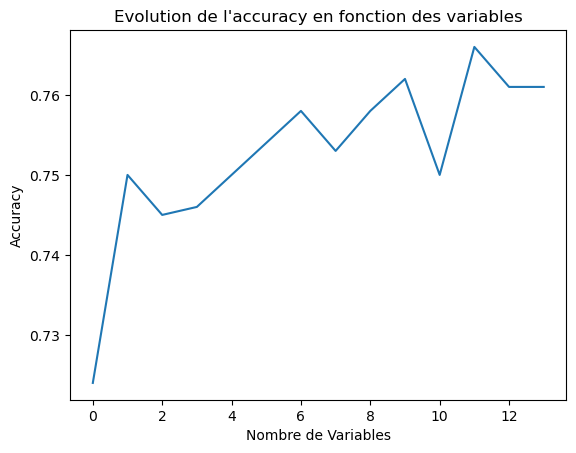

MLP


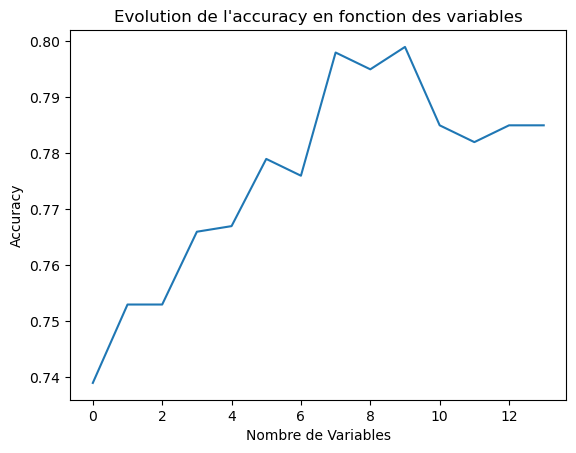

Bagging


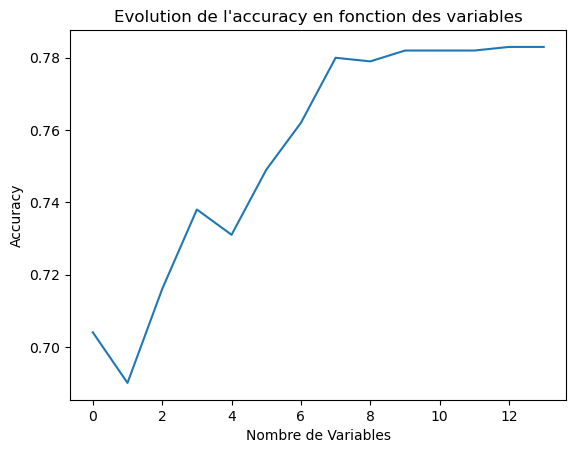

AdaBoost


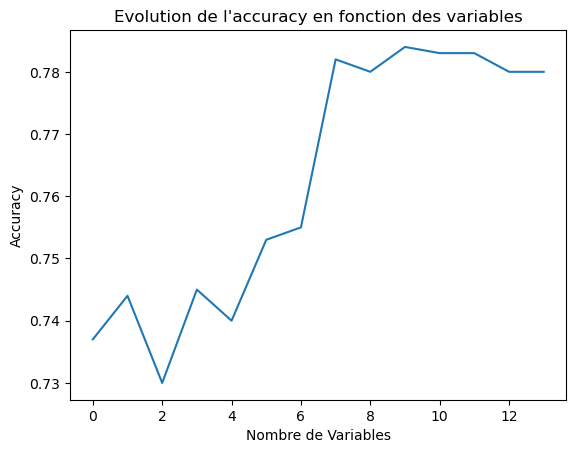

In [ ]:
best_clfs = {
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1),
    'Bagging': BaggingClassifier(n_estimators=200, random_state=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=1),
}

# Trouver le nombre de variables optimales pour chaque algorithme
for clf_name, clf in clfs.items():
    print(clf_name)
    number_variables_to_keep(X_train_norm, X_test_norm, y_test, y_train, sorted_idx, clf)

Ainsi, on remarque que le nombre de variables pour les meilleurs algos est (on rajoute 1 à ce que l'on voit sur le tableau) :
* Naive Bayes => 12
* MLP => 10
* Bagging => 13
* AdaBoost => 10

In [ ]:
best_number_variables = {
    'Naive Bayes': 12,
    'MLP': 10,
    'Bagging': 13,
    'AdaBoost': 10,
}

### C - Recherche des paramètres optimaux (meilleurs algos)

Nous avons déjà récupèré les meilleurs paramètres pour le MLP qui étaient : 
* Fonction d'activation: logistic
* hidden_layer_sizes: (40,10)

In [ ]:
# Recherche des meilleurs paramètres pour les classifieurs
clfs_to_test = {
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

params = {
    'Bagging': {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
    }
}

best_params = {}

for i in clfs_to_test:
    print("\n-------------------")
    print("ALGO : ", i)
    # On supprime les variables les moins importantes
    X_train_norm_bv = X_train_norm[:, sorted_idx[:best_number_variables[i]]]
    X_test_norm_bv = X_test_norm[:, sorted_idx[:best_number_variables[i]]]
    best_params[i] = find_best_variables(X_train_norm_bv, y_train, X_test_norm_bv, y_test, clfs_to_test[i], params[i])


-------------------
ALGO :  Bagging


Meilleurs paramètres trouvés:
{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}
Accuracy du modèle sur l'ensemble de test: 0.7961608775137111
Precision du modèle sur l'ensemble de test: 0.7481623037907743
Score du modèle sur l'ensemble de test (accuracy + precision) / 2: 0.8156304976496707

-------------------
ALGO :  AdaBoost
Meilleurs paramètres trouvés:
{'learning_rate': 0.5, 'n_estimators': 100}
Accuracy du modèle sur l'ensemble de test: 0.7993601462522852
Precision du modèle sur l'ensemble de test: 0.7581190864921219
Score du modèle sur l'ensemble de test (accuracy + precision) / 2: 0.8129715734113679


Ainsi, on les meilleurs parametres et les meilleurs nombres de variables pour chaque classifieur. On peut donc les utiliser pour entrainer nos classifieurs et les sauvegarder dans des fichiers pickle.

In [ ]:
best_params

{'Bagging': {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50},
 'AdaBoost': {'learning_rate': 0.5, 'n_estimators': 100},
 'Naive Bayes': {'var_smoothing': 1e-09}}

### D - Comparaison finale (meilleurs algos)

In [ ]:
best_final_clfs = {
    'Naive Bayes': GaussianNB(),
    'Bagging': BaggingClassifier(random_state=1, **best_params.get('Bagging', {})),
    'AdaBoost': AdaBoostClassifier(random_state=1, **best_params.get('AdaBoost', {})),
    'MLP': MLPClassifier(**best_params_mlp),
}

In [ ]:
best_final_clfs

{'Naive Bayes': GaussianNB(),
 'Bagging': BaggingClassifier(max_samples=0.5, n_estimators=50, random_state=1),
 'AdaBoost': AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=1),
 'MLP': MLPClassifier(activation='logistic', hidden_layer_sizes=(40, 20))}

On relance nos meilleurs algos avec les meilleurs paramètres sans normalisation : 

In [ ]:
# Exécuter la fonction sur les données originales
run_classifiers(best_final_clfs, X, y, sorted_idx, best_number_variables)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.803      | 0.778      | 0.829      | 0.019      | 0.018      | 0.793      | 0.027      | 0.081     


Bagging              | 0.803      | 0.783      | 0.822      | 0.013      | 0.016      | 0.829      | 0.019      | 49.094    
AdaBoost             | 0.806      | 0.792      | 0.819      | 0.018      | 0.020      | 0.833      | 0.022      | 9.516     
MLP                  | 0.777      | 0.764      | 0.790      | 0.022      | 0.023      | 0.754      | 0.034      | 22.752    


On relance nos meilleurs algos avec les meilleurs paramètres avec normalisation : 

In [ ]:
X_norm = normalize_data_one(X)
run_classifiers(best_final_clfs, X_norm, y, sorted_idx, best_number_variables)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.804      | 0.770      | 0.837      | 0.018      | 0.016      | 0.798      | 0.027      | 0.078     


Bagging              | 0.803      | 0.784      | 0.823      | 0.012      | 0.016      | 0.829      | 0.019      | 48.946    
AdaBoost             | 0.806      | 0.792      | 0.819      | 0.018      | 0.020      | 0.833      | 0.022      | 9.281     
MLP                  | 0.808      | 0.791      | 0.825      | 0.014      | 0.019      | 0.825      | 0.021      | 25.871    


On peut voir que la normalisation améliore le Naive Bayes et le MLP, on va donc seulement comparer les algos sur les données normalisées.


Ainsi, on remarque que avec les meilleurs paramètres les modèles sont toujours très proches. 
L'aire sous la courbe, les accuracy et les precisions sont très bonnes et proches pour le bagging, le MLP et le Adaboost.
La sensible différence entre tous ces algos est le temps d'execution. Le bagging met 48 secondes a s'executer, le MLP mets 2 fois moins de temps soit 25 secondes, et le AdaBoost mets plus de 2 fois moins de temps que le MLP soit 9 secondes. On peut voir que le Naive Bayes et les plus performant en termes de temps et de long puisque nous sommes a 0.078 secondes.

Ainsi pour des performances assez similaires même si l'on a une accuracy  et une AUC plus faible que les autres algorithmes mais une très bonne précision avec le Naive Bayes, ce dernier s'execute très vite et serait donc adapté si nous avons une contrainte de temps dans le contexte d'utilsiation des modèles. Si dans le contexte d'utilisation le but est de maximiser l'accuracy, la precision et l'AUC alors le meilleur des modèles est le MLP (très serré avec le AdaBoost). 


### E - Creation de la pipeline

Dans les questions précédentes, nous avons déjà créer une pipeline pour le MLP. Ainsi, nous pouvons créer une pipeline pour notre deuxième meilleur algo, le AdaBoost.

In [ ]:
# Créer le pipeline
pipeline_adaline = Pipeline([
    ('scaler', StandardScaler()),  # Normalisation des données
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)),
    ('classifier', AdaBoostClassifier(random_state=1, learning_rate=0.5, n_estimators=100))  # MLPClassifier
])

# Entraîner le pipeline sur les données d'entraînement
pipeline_adaline.fit(X_train, y_train)

# Sauvegarder le pipeline dans un fichier pickle
with open('pipeline_adaline.pkl', 'wb') as file:
    pickle.dump(pipeline_adaline, file)

# II. Apprentissage supervisé : Données hétérogènes

In [6]:
data = pd.read_csv("credit.data", sep="\t", header=None)
X, y= get_data_variables(data)


In [4]:
X_numeric = keep_only_numeric(X)

nan_indices = np.any(np.isnan(X_numeric), axis=1)
X_float_without_nan = X_numeric[~nan_indices]
y_without_nan = y[~nan_indices]

L'échantillon contient 666  individus décrits par 6 variables
Pourcentage de positifs :  44.8948948948949
Pourcentage de négatifs :  55.1051051051051


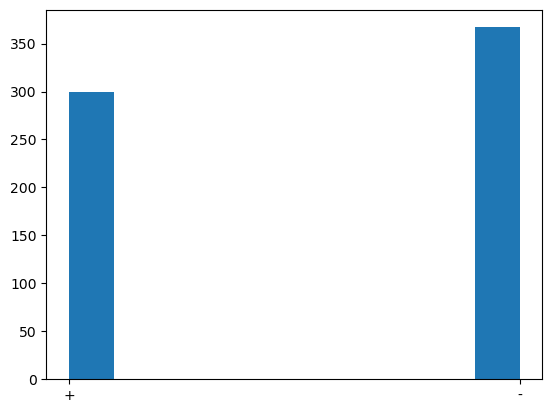

In [46]:
analyse_data_properties_2(X_float_without_nan, y_without_nan)

In [71]:
# Binarisation des variables
y_binary = binarisation(y_without_nan)

#### Tableau des performances des algorithmes avec les données non-normalisés

In [23]:
# Définir les algorithmes à comparer
clfs = {
    'Naive Bayes': GaussianNB(),
    'CART': DecisionTreeClassifier(random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy', random_state=1),
    'STUMP': DecisionTreeClassifier(max_depth=1, random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Bagging': BaggingClassifier(n_estimators=200, random_state=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=1),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=1)
}

In [73]:
# Exécuter la fonction sur les données originales
run_classifiers(clfs, X_float_without_nan, y_binary)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.774      | 0.716      | 0.832      | 0.050      | 0.052      | 0.793      | 0.058      | 0.051     
CART                 | 0.698      | 0.716      | 0.680      | 0.047      | 0.045      | 0.711      | 0.051      | 0.124     
ID3                  | 0.722      | 0.739      | 0.705      | 0.038      | 0.053      | 0.734      | 0.045      | 0.136     
STUMP                | 0.804      | 0.743      | 0.864      | 0.064      | 0.077      | 0.723      | 0.052      | 0.069     
MLP                  | 0.698      | 0.694      | 0.701      | 0.055      | 0.070      | 0.724      | 0.064      | 1.777     
KNN                  | 0.730      | 0.704      | 0.756      | 0.055      | 0.075      | 0.745      | 0.042      | 0.

#### Tableau des performances des algorithmes avec les données normalisés (StandardScaler)

In [ ]:
# Normalisation de X
X_norm = normalize_data_one(X_float_without_nan)
run_classifiers(clfs, X_norm, y_binary)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.774      | 0.716      | 0.832      | 0.050      | 0.052      | 0.793      | 0.058      | 0.037     
CART                 | 0.697      | 0.716      | 0.679      | 0.048      | 0.048      | 0.711      | 0.052      | 0.092     
ID3                  | 0.722      | 0.739      | 0.705      | 0.038      | 0.053      | 0.734      | 0.045      | 0.101     
STUMP                | 0.804      | 0.743      | 0.864      | 0.064      | 0.077      | 0.723      | 0.052      | 0.053     
MLP                  | 0.784      | 0.776      | 0.791      | 0.034      | 0.057      | 0.839      | 0.044      | 5.255     
KNN                  | 0.780      | 0.737      | 0.822      | 0.056      | 0.052      | 0.818      | 0.046      | 0.

#### Tableau des performances des algorithmes avec les données normalisés (MinMaxScaler)

In [ ]:
min_max_scaler = MinMaxScaler()
X_norm_minmax = min_max_scaler.fit_transform(X_float_without_nan)
run_classifiers(clfs, X_norm_minmax, y_binary)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Naive Bayes          | 0.774      | 0.716      | 0.832      | 0.050      | 0.052      | 0.793      | 0.058      | 0.052     
CART                 | 0.698      | 0.716      | 0.680      | 0.047      | 0.045      | 0.711      | 0.051      | 0.156     
ID3                  | 0.723      | 0.740      | 0.706      | 0.039      | 0.053      | 0.736      | 0.045      | 0.126     
STUMP                | 0.804      | 0.743      | 0.864      | 0.064      | 0.077      | 0.723      | 0.052      | 0.055     
MLP                  | 0.795      | 0.767      | 0.822      | 0.049      | 0.075      | 0.826      | 0.056      | 5.399     
KNN                  | 0.776      | 0.728      | 0.823      | 0.070      | 0.082      | 0.799      | 0.073      | 0.

On remarque que les résulats ne changent que très peu lorsque les données sont normalisées. On peut conclure que les données de bases sont déjà quasiement toutes normalisées.

Pour les algorithmes, nous n'avons pas choisis les meilleurs paramètres cela peut donc impacter leur performances.

Ainsi, on peut voir que les algorithmes qui maximisent en même temps l'accuracy, la precision et l'AUC sont avec les données normalisés en utilisant Standard Scaler : 
* Bagging
* Random Forest
* MLP

Même si les aures algorithmes sont tout de même assez bon sauf le CART qui est vraiment moins bon que les autres.

On ne prends pas le stump par exemple car l'AUC est faible comparé aux autres. De plus, on remarque que le bagging est beeaucoup plus long que les deux autres (~2x)

On peut remarque de meilleurs résultats en utilisant MinMaxScaler pour normaliser les données mais on a toujours les memes meilleurs algorithmes.


In [21]:
X_final = get_final_imputed_dataset(X)
y_final = np.where(y == '+', 1, 0)

On remarque que l'on a bien plus de variables, on est passé de 15 à 46.

In [19]:
X_final.shape

(688, 46)

#### Tableau des performances des algorithmes avec les données non-normalisés

In [29]:
# Exécuter la fonction sur les données originales
run_classifiers(clfs, X_final, y_final)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------


Random Forest        | 0.868      | 0.879      | 0.857      | 0.037      | 0.052      | 0.931      | 0.029      | 12.544    
Bagging              | 0.868      | 0.878      | 0.858      | 0.035      | 0.044      | 0.928      | 0.027      | 17.374    
XGBoost              | 0.852      | 0.862      | 0.842      | 0.044      | 0.074      | 0.927      | 0.026      | 2.551     
Naive Bayes          | 0.842      | 0.836      | 0.848      | 0.044      | 0.065      | 0.915      | 0.038      | 0.064     
STUMP                | 0.823      | 0.856      | 0.789      | 0.044      | 0.074      | 0.866      | 0.040      | 0.064     
AdaBoost             | 0.817      | 0.830      | 0.805      | 0.032      | 0.048      | 0.903      | 0.034      | 10.385    
CART                 | 0.816      | 0.830      | 0.802      | 0.039      | 0.064      | 0.830      | 0.040      | 0.118     
ID3                  | 0.802      | 0.812      | 0.792      | 0.047      | 0.083      | 0.810      | 0.048      | 0.142     


On peut voir que les résultats sont bien meilleur en gardant toutes les données.
En effet, on remarque que l'on a une meilleure accuracy, precision et aire sous la courbe pour chacun de nos algorithmes. Les performances de temps sont cependant indentiques ce qui est plutôt normal car nous faisant le même nombre de traitements pour l'apprentissage (plus ou moins).

On monte a 0.879 d'accuracy alors que précédemment nous ne depassions pas 0.791
On monte a 0.857 de précision alors que précédemment nous ne depassions pas 0.802
On monte a 0.931 d'AUC alors que précédemment nous ne depassions pas 0.836

Les meilleurs algorithmes sont donc :
* Random Forest
* Bagging
* XGBoost

#### Tableau des performances des algorithmes avec les données normalisés (StandardScaler) :

In [30]:
# Normalisation de X
X_norm_final = normalize_data_one(X_final)
run_classifiers(clfs, X_norm_final, y_final)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------


Bagging              | 0.868      | 0.878      | 0.858      | 0.035      | 0.044      | 0.928      | 0.027      | 17.375    
Random Forest        | 0.867      | 0.878      | 0.856      | 0.038      | 0.053      | 0.931      | 0.029      | 9.209     
XGBoost              | 0.852      | 0.862      | 0.842      | 0.044      | 0.074      | 0.927      | 0.026      | 2.552     
MLP                  | 0.837      | 0.844      | 0.830      | 0.044      | 0.068      | 0.909      | 0.044      | 8.765     
KNN                  | 0.837      | 0.817      | 0.856      | 0.047      | 0.082      | 0.895      | 0.039      | 0.638     
STUMP                | 0.823      | 0.856      | 0.789      | 0.044      | 0.074      | 0.866      | 0.040      | 0.060     
CART                 | 0.818      | 0.831      | 0.805      | 0.038      | 0.064      | 0.832      | 0.039      | 0.115     
AdaBoost             | 0.817      | 0.830      | 0.805      | 0.032      | 0.048      | 0.903      | 0.034      | 9.624     


Avec la normalisation on remarque que nos meilleurs algorithmes sont toujours les mêmes. Cependant cette fois le bagging est legerement meilleur que le Random Forest. Le XGBoost n'a lui pas bougé.

De plus, on remarque que la suite de la list est différente de précédemment. En effet, on remarque le MLP en 4 position qui était l'un des pires algorithmes juste avant (cet algo est bien meilleure avec une normalisation des données). Contrairement le Naive Bayes qui était à la 4e position est maitenant à la dernière.

#### Tableau des performances des algorithmes avec les données normalisés (MinMax) :

In [27]:
min_max_scaler = MinMaxScaler()
X_norm_minmax = min_max_scaler.fit_transform(X_final)
run_classifiers(clfs, X_norm_minmax, y_final)

Classifier           | AP         | Acc        | Precision  | Std Acc    | Std Precision | AUC        | Std AUC    | Time      
----------------------------------------------------------------------------------------------------------------------------------
Random Forest        | 0.868      | 0.879      | 0.857      | 0.037      | 0.052      | 0.931      | 0.029      | 9.413     
Bagging              | 0.868      | 0.878      | 0.858      | 0.035      | 0.044      | 0.928      | 0.027      | 18.988    
KNN                  | 0.861      | 0.862      | 0.860      | 0.038      | 0.055      | 0.910      | 0.034      | 0.688     
XGBoost              | 0.852      | 0.862      | 0.842      | 0.044      | 0.074      | 0.927      | 0.026      | 3.669     
MLP                  | 0.838      | 0.847      | 0.829      | 0.045      | 0.073      | 0.914      | 0.039      | 9.235     
STUMP                | 0.823      | 0.856      | 0.789      | 0.044      | 0.074      | 0.866      | 0.040      | 0.

Les meilleurs algorithmes sont donc :
* Random Forest
* Bagging
* KNN

Avec cette normalisation on remarque que le random Forest et le Bagging sont toujours nos meilleurs algorithmes mais que le XGBoost a été détroné par le KNN avec une meilleure accuracy et précision.

#### Conclusion

Ainsi, nous avons pu voir que garder toutes les données et les imputés peut avoir un impact positif sur l'apprentissage et permettre d'atteindre de meilleure score. D'autant plus, que nous n'avons pas encore tout optimisé. En effet, il pourrait être intéressant de voir si toutes les variables de ce dataset sont nécessaire mais aussi de trouver les paramètres optimaux de nos meilleurs alogrithmes afin d'améliorer encore plus notre modèle.